# A Closer Look at Model-Based Policy Gradients

---
## Linear Quadratic Gaussian (LQG) Problems
In what follows we consider MDPs with:
1. continuous state space $\mathbf{s} \in \mathcal{S} = \mathbb{R}^n$
2. continuous action space $\mathbf{a} \in \mathcal{A} = \mathbb{R}^d$
3. finite time horizon $N \in \mathbb{N}$ and timesteps $t \in \mathcal{T} = \{0, \dots, N - 1\}$
4. time-varying linear Gaussian dynamics $$
    \mathbf{s}_{t+1} \sim p(\cdot| \mathbf{s}_t, \mathbf{a}_t) = \mathcal{N}\left( \cdot ~\middle|~ \mathbf{F}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} + \mathbf{f}_t, \mathbf{\Sigma}_{t} \right)
    $$
5. time-varying quadratic costs $$
    r_{t+1} = R(\mathbf{s}_t, \mathbf{a}_t) = - \tfrac{1}{2} \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}^\intercal \mathbf{C}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} + \mathbf{c}_t^\intercal \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}
    $$
6. Gaussian-distributed initial state $$
    \mathbf{s}_0 \sim \rho = \mathcal{N}(\mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho)
    $$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from gym.spaces import Box
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from torch import Tensor


import raylab
import lqsvg.envs.environments.lqr.named as named
import lqsvg.torch.named as nt
from lqsvg.envs import lqr

In [2]:
seed = \
0
# 42
# 69
n_state, n_ctrl, horizon = 2, 2, 100
n_tau = n_state + n_ctrl

In [3]:
dynamics, cost = lqr.make_lqg(state_size=n_state, ctrl_size=n_ctrl, horizon=horizon, stationary=True, np_random=seed)
# Pretend expected first state is all zeros
init_mean = torch.zeros(n_state, names="R".split())
# Pretend first noise covariance is the identity
init_cov = torch.eye(n_state).refine_names(*"R C".split())

print(f"""
Dynamics:
    F: {dynamics.F.shape}, {dynamics.F.names}
    f: {dynamics.f.shape}, {dynamics.f.names}
    W: {dynamics.W.shape}, {dynamics.W.names}

Cost:
    C: {cost.C.shape}, {cost.C.names}
    c: {cost.c.shape}, {cost.c.names}
    
Initial state:
    mean: {init_mean.shape}, {init_mean.names}
    covariance: {init_cov.shape}, {init_cov.names}
""")


Dynamics:
    F: torch.Size([100, 2, 4]), ('H', 'R', 'C')
    f: torch.Size([100, 2]), ('H', 'R')
    W: torch.Size([100, 2, 2]), ('H', 'R', 'C')

Cost:
    C: torch.Size([100, 4, 4]), ('H', 'R', 'C')
    c: torch.Size([100, 4]), ('H', 'R')
    
Initial state:
    mean: torch.Size([2]), ('R',)
    covariance: torch.Size([2, 2]), ('R', 'C')



/Users/angelolovatto/Repositories/personal/raylab-experiments/addons/envs/environments/lqr/utils.py:19: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.as_tensor(array, dtype=torch.float32)
/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/addons-yHiyTTNU-py3.8/lib/python3.8/site-packages/torch/tensor.py:775: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:848.)
  return super(Tens

## Time-varying linear policy

A time-varying linear policy is a mapping $\mu_\theta: \mathcal{S}\times\mathcal{T} \mapsto \mathcal{A}$ such that
$$
    \mu_\theta(\mathbf{s}, t) = \mathbf{K}_t \mathbf{s} + \mathbf{k}_t
    \,,
$$
where $\mathbf{K}_t \in \mathbb{R}^{d\times n}$, $\mathbf{k}_t \in \mathbb{R}^d$ and $\theta = \{\mathbf{K}_t, \mathbf{k}_t\}_{t\in\mathcal{T}}$.

In [4]:
from policy import TVLinearFeedback

## Quadratic State-value

$$
        V^\mu(\mathbf{s}, t) = {\tfrac12} \mathbf{s}^\intercal\mathbf{V}_t\mathbf{s} + \mathbf{v}_t^\intercal\mathbf{s} + v_t, \quad t\in\mathcal{T}^+ \,,
$$

In [5]:
from typing import Optional

class ValueFn(nn.Module):
    def __init__(self, quadratic: lqr.Quadratic, timestep: int = 0):
        super().__init__()
        V, v, c = (x.select("H", timestep) for x in quadratic)
        self.register_buffer("V", V.align_to("R", "C"))
        self.register_buffer("v", v.align_to("R", "C"))
        self.register_buffer("c", c.align_to("R", "C"))
        assert len(self.V.shape) == len(self.v.shape) == len(self.c.shape) == 2, \
            (self.V.shape, self.v.shape, self.c.shape)
        
    def symeig(self) -> Tensor:
        return torch.symeig(self.V.rename(None))

    def forward(self, state: Tensor):
        """Calculate optimal state-value.

        May be used with batched states.
        """
        s = nt.refine_vector_input(state)
        value = nt.transpose(s) @ self.V @ s / 2 \
                + nt.transpose(self.v) @ s \
                + self.c
        return nt.refine_scalar_output(value)
    
    def min(self):
        Vinv = self.V.rename(None).inverse()
        return nt.refine_vector_output(-Vinv @ self.v)
    
    def expected(self, mean: Tensor, cov: Tensor):
        """Expected cost given mean and covariance matrix of the initial state.
        
        https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation.
        """
        mean = nt.refine_vector_input(mean)
        cov = nt.refine_matrix_input(cov)
        value = nt.trace(cov @ self.V).align_to(..., "R", "C") / 2 \
            + nt.transpose(mean) @ self.V @ mean \
            + nt.transpose(self.v) @ mean \
            + self.c
        return nt.refine_scalar_output(value)
            
    def plot_3d(self, ax, mean: Optional[Tensor] = None, amp: float = 10):
        if mean is None:
            mean = self.min().detach().numpy()
        else:
            mean = mean.detach().numpy()

        xrange = np.linspace(mean[0] -amp, mean[0] + amp, num=100)
        yrange = np.linspace(mean[1] -amp, mean[1] + amp, num=100)
        xbatch, ybatch = np.meshgrid(xrange, yrange)
        assert xbatch.shape == ybatch.shape == (100, 100)

        init_states = np.stack([xbatch, ybatch], axis=-1).reshape((-1, 2))
        init_states = torch.from_numpy(init_states).float().refine_names("B", "R")
        assert init_states.shape == (10000, 2), init_states.shape

        init_values = self(init_states).detach().numpy()
        assert init_values.shape == (10000,), init_values.shape

        init_values = init_values.reshape(xbatch.shape)
        ax.plot_surface(xbatch, ybatch, init_values, cmap=cm.coolwarm)
        
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("value")

# Exact methods
---
## LQG control

<img src="images/LQG - Control.png" width=800>

In [6]:
def print_solution(policy, qval, vval):
    K, k = policy
    Q, q, qc = qval
    V, v, vc = vval
    
    print(f"""
    Policy:
        K: {K.shape}, {K.names}
        k: {k.shape}, {k.names}
    """)
    
    print(f"""
    Q-value:
        Q: {Q.shape}, {Q.names}
        q: {q.shape}, {q.names}
        const: {qc.shape}, {qc.names}
    """)

    print(f"""
    V-value:
        V: {V.shape}, {V.names}
        V: {v.shape}, {v.names}
        const: {vc.shape}, {vc.names}
    """)


lqg_control = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
pistar, qstar, vstar = lqg_control(dynamics, cost)
print_solution(pistar, qstar, vstar)


    Policy:
        K: torch.Size([100, 2, 2]), ('H', 'R', 'C')
        k: torch.Size([100, 2]), ('H', 'R')
    

    Q-value:
        Q: torch.Size([100, 4, 4]), ('H', 'R', 'C')
        q: torch.Size([100, 4]), ('H', 'R')
        const: torch.Size([100]), ('H',)
    

    V-value:
        V: torch.Size([101, 2, 2]), ('H', 'R', 'C')
        V: torch.Size([101, 2]), ('H', 'R')
        const: torch.Size([101]), ('H',)
    


In [7]:
vstar_fn = ValueFn(vstar)
print(vstar_fn.V)
print(vstar_fn.v)
print(vstar_fn.c)

tensor([[0.7519, 0.0669],
        [0.0669, 0.4993]], names=('R', 'C'))
tensor([[ 0.4185],
        [-0.0853]], names=('R', 'C'))
tensor([[108.5435]], names=('R', 'C'))


### Optimal value for best initial state
$$
\begin{align}
\mathbf{s}_{min} 
&= \arg\min_{\mathbf{s}} V^\star(\mathbf{s}, 0) \\
&= \arg\min_{\mathbf{s}} \mathbf{s}^\intercal \mathbf{V}_0^\star \mathbf{s} + {\mathbf{v}_0^\star}^\intercal \mathbf{s} + v_0^\star \\
&= -{\mathbf{V}_0^\star}^{-1} \mathbf{v}_0^\star \\
\end{align}
$$

In [8]:
minimum = vstar_fn.min()
print(f"""
    Best initial state: {minimum}
    Best initial value: {vstar_fn(minimum)}
""")


    Best initial state: tensor([-0.5786,  0.2483], names=('R',))
    Best initial value: 108.41183471679688



### Optimal expected initial state value
$$
\mathbb{E}_{\mathbf{s}\sim\rho} \left[ V^{\star}(\mathbf{s}, 0) \right]
= \text{Tr}(\mathbf{V}_0\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0 \mathbf{\mu}_0 + \mathbf{v}_0^\intercal \mathbf{\mu}_0 + v_0
$$

In [9]:
print(f"""
    Mean: {init_mean}
    Covariance: {init_cov}
    Expected value: {vstar_fn.expected(init_mean, init_cov)}
""")


    Mean: tensor([0., 0.], names=('R',))
    Covariance: tensor([[1., 0.],
        [0., 1.]], names=('R', 'C'))
    Expected value: 109.16909790039062



### Optimal value for each initial state

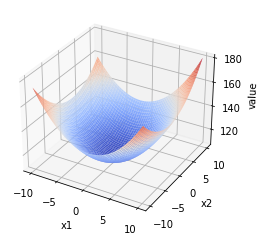

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
vstar_fn.plot_3d(ax, mean=init_mean)
# plt.savefig("navigation2d_value.png")
plt.show()

In [11]:
print(vstar_fn.symeig())

torch.return_types.symeig(
eigenvalues=tensor([0.4827, 0.7686]),
eigenvectors=tensor([]))


## LQG prediction (Policy Evaluation)

<img src="images/LQG - Prediction.png" width=800>

In [12]:
lqg_prediction = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)

## Perturbed optimal policies

We generate sub-optimal policies by adding uniform noise to the optimal policy's parameters, i.e., 
$$
    \mathbf{K}_t = \mathbf{K}_t^\star + \epsilon, \qquad \epsilon \sim \mathcal{U}(\mathbf{0}, \mathbf{0.5}) \\
    \mathbf{k}_t = \mathbf{k}_t^\star + \epsilon, \qquad \epsilon \sim \mathcal{U}(\mathbf{0}, \mathbf{0.5})
$$

In [13]:
def rand_policy(policy, seed):
    K, k = policy
    torch.manual_seed(seed)
    K = K + torch.rand_like(K) * 0.5
    k = k + torch.rand_like(k) * 0.5
    return (K, k)

In [14]:
policy = rand_policy(pistar, seed=seed)

_, vval = lqg_prediction(policy, dynamics, cost)
vval_fn = ValueFn(vval)
min_state = vval_fn.min()
print(f"""
    V: {vval_fn.V}
    v: {vval_fn.v}
    c: {vval_fn.c}
    
    min state: {min_state}
    min value: {vval_fn(min_state)}
""")


    V: tensor([[1.3181, 1.0737],
        [1.0737, 2.3034]], names=('R', 'C'))
    v: tensor([[-2.4610],
        [-5.6640]], names=('R', 'C'))
    c: tensor([[2056.7476]], names=('R', 'C'))
    
    min state: tensor([-0.2192,  2.5611], names=('R',))
    min value: 2049.76416015625



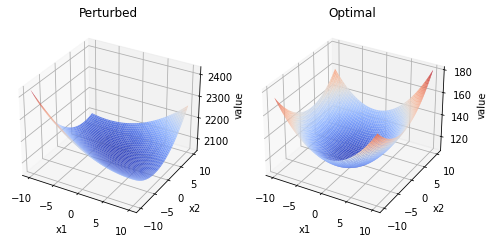

In [15]:
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(1, 2, 1, projection="3d")
vval_fn.plot_3d(ax, mean=init_mean)
ax.set_title("Perturbed")

ax = fig.add_subplot(1, 2, 2, projection="3d")
vstar_fn.plot_3d(ax, mean=init_mean)
ax.set_title("Optimal")

# plt.savefig("navigation2d_value.png")
plt.show()

In [16]:
print(vval_fn.symeig())
print(vstar_fn.symeig())

torch.return_types.symeig(
eigenvalues=tensor([0.6294, 2.9921]),
eigenvectors=tensor([]))
torch.return_types.symeig(
eigenvalues=tensor([0.4827, 0.7686]),
eigenvectors=tensor([]))


## Policy learning via true value gradients

LQG prediction can be seen as a function mapping policy parameters (with the dynamics kept constant) to value function coefficients:
$$
\left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right) = \text{LQGPrediction}(\theta)
$$

Thus, we can write each coeficient as a function of policy parameters. For example, the value function for a policy $\mu_\theta$ would be:
$$
V^\mu(\mathbf{s}, t) = \tfrac12 \mathbf{s}^\intercal \mathbf{V}_t(\theta) \mathbf{s} + \mathbf{v}_t(\theta)^\intercal \mathbf{s} + v_t(\theta)
$$

We can then express policy performance as a direct function of policy parameters:
$$
\begin{align}
J(\theta) 
    &= \mathbb{E}_{\mathbf{s}\sim\rho} \left[ \tfrac12 \mathbf{s}^\intercal \mathbf{V}_0(\theta) \mathbf{s} + \mathbf{v}_0(\theta)^\intercal \mathbf{s} + v_0(\theta) \right] \\
    &= \text{Tr}(\mathbf{V}_0(\theta)\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0(\theta) \mathbf{\mu}_0 + \mathbf{v}_0(\theta)^\intercal \mathbf{\mu}_0 + v_0(\theta)
\end{align}
$$

In [17]:
class TVLFLoss(nn.Module):
    def __init__(
        self, 
        dynamics: lqr.LinDynamics,
        cost: lqr.QuadCost,
        init_mean: Tensor,
        init_cov: Tensor,
    ):
        super().__init__()
        n_state = dynamics.F.size("R")
        n_ctrl = dynamics.F.size("C") - n_state
        horizon = dynamics.F.size("H")
        self.predict = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
        self.dynamics = dynamics
        self.cost = cost
        self.init_mean = init_mean
        self.init_cov = init_cov
        
    def forward(self, policy: lqr.Linear):
        _, vval = self.predict(policy, self.dynamics, self.cost)
        vval_fn = ValueFn(vval)
        cost = vval_fn.expected(self.init_mean, self.init_cov)
        return cost

In [18]:
loss_fn = TVLFLoss(
    dynamics, 
    cost, 
    init_mean=init_mean,
    init_cov=init_cov
)

loss = loss_fn(policy)
print("Random policy loss:", loss)

Random policy loss: tensor(2058.5583)


Finally, since the value function coefficients are differentiable functions of the policy parameters, we can optimize the latter for better performance via gradient ascent
$$
\theta \gets \theta + \alpha \nabla_{\theta} J(\theta)
$$

In [19]:
tvlp = TVLinearFeedback.from_existing(policy)
optim = torch.optim.Adam(tvlp.parameters(), lr=1e-3)

# for i in range(100):
for i in range(1):
    for p in tvlp.parameters():
        p.grad = None
    loss = loss_fn(tvlp.gains())
    loss.backward()
    optim.step()
    if i % 100 == 0:
        print("Loss:", loss.item())
print("Loss:", loss_fn(tvlp.gains()).item())
print("Best possible:", vstar_fn.expected(loss_fn.init_mean, loss_fn.init_cov).item())

Loss: 2058.558349609375
Loss: 1959.4395751953125
Best possible: 109.16909790039062


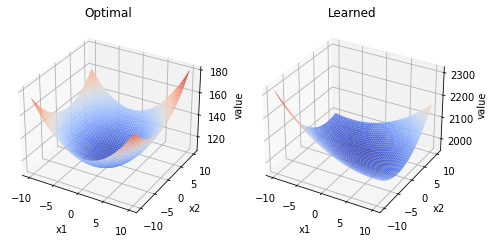

In [20]:
learned_vval = ValueFn(lqg_prediction(tvlp.gains(), dynamics, cost)[1])
fig = plt.figure(figsize=(8, 16))

ax = fig.add_subplot(1, 2, 1, projection="3d")
vstar_fn.plot_3d(ax, mean=init_mean)
ax.set_title("Optimal")

ax = fig.add_subplot(1, 2, 2, projection="3d")
learned_vval.plot_3d(ax, mean=init_mean)
ax.set_title("Learned")

plt.show()

# Sample-based methods
---

## Core idea: learn a dynamics model to estimate policy performance and gradient

<!-- Our model has the same structure of the dynamics, i.e.,  -->
1. Define an parametrized dynamics model
    $$
    p_\psi (\cdot | \mathbf{s}, \mathbf{a}, t) = \mathcal{N} \left( \cdot ~\middle|~ \hat{\mathbf{F}}_t \begin{bmatrix}\mathbf{s} \\ \mathbf{a}\end{bmatrix} + \hat{\mathbf{f}}_t, \hat{\mathbf{\Sigma}}_{t+1} \right) \\
    \text{ and } 
    \rho_\psi(\cdot) = \mathcal{N} \left( \cdot ~\middle|~ \hat{\mathbf\mu}_0, \hat{\mathbf\Sigma}_0 \right) \,,
    $$
    where $\psi = \{ \hat{\mathbf\mu}_0, \hat{\mathbf\Sigma}_0 \} \cup \{ \hat{\mathbf F}_i, \hat{\mathbf f}_i, \hat{\mathbf\Sigma}_{i+1} \}_{i=0}^{N-1}$ denotes the model parameters.
2. Optimize the model to be "close" to the true dynamics
    $$
    \psi^\star = \arg\min_\psi D(p^*, p_\psi)
    $$
3. Compute the **Model-based Policy Gradient**:
    $$
    \nabla J(\theta) = \mathbb{E}_{\mathbf{s}\sim d^\mu} 
        \left[ \nabla_\theta R(\mathbf{s}, \mu_\theta(\mathbf{s})) + \gamma \nabla_\theta \mathbb{E}_{\mathbf{s}'\sim p_\psi(\mathbf{s}, \mu_\theta(\mathbf{s}))} V^\mu(\mathbf{s}') \right]
    $$


## Model-based Policy Evaluation
1. Collect trajectory data with policy
2. Train a time-varying linear Gaussian dynamics model on trajectory data
3. Estimate policy performance (expected return) by sampling from the model

**Note**: we assume access to the true reward function

### 1. Collect trajectory data with policy

In [21]:
from typing import List, Optional

from raylab.policy import TorchPolicy
from raylab.policy.action_dist import WrapDeterministicPolicy
from raylab.policy.modules.actor import DeterministicPolicy
from raylab.utils.types import TensorDict
from raylab.torch.nn.distributions import Distribution
from raylab.torch.nn.distributions.types import DistParams, SampleLogp
from lqsvg.policy.modules.model import TVLinearModel, InitStateModel, QuadraticReward
from lqsvg.envs.environments.lqr.gym import LQGEnv
from lqsvg.envs.environments.lqr.solvers import transpose
from lqsvg.envs.environments.lqr.utils import as_float_tensor, dims_from_spaces, make_spd_matrix

#### Define PyTorch policy

In [22]:
from policy import LQGPolicy

#### Collect a single trajectory

In [23]:
import lqsvg
from ray.rllib import RolloutWorker, SampleBatch
from raylab.envs import get_env_creator
lqsvg.register_all()

# Create and initialize
worker = RolloutWorker(
    env_creator=get_env_creator("RandomLQG"),
    env_config={"n_state": n_state, "n_ctrl": n_ctrl, "horizon": horizon, "gen_seed": seed},
    policy_spec=LQGPolicy,
    policy_config={},
    rollout_fragment_length=1, 
    batch_mode="complete_episodes"
)
assert isinstance(worker.env, LQGEnv)
worker.foreach_trainable_policy(lambda p, _: p.initialize_from_lqg(worker.env))
def test_worker(worker: RolloutWorker):
    samples = worker.sample()

    print("Count:", samples.count)
    idxs = np.random.permutation(samples.count)[:10]
    for k in samples.keys():
        print("Key:", k)
        print(samples[k][idxs])
        print(samples[k][idxs].dtype)
        
test_worker(worker)

Count: 100
Key: t
[75 62 56 58 40  0 91 67 39 41]
int64
Key: eps_id
[1399389574 1399389574 1399389574 1399389574 1399389574 1399389574
 1399389574 1399389574 1399389574 1399389574]
int64
Key: agent_index
[0 0 0 0 0 0 0 0 0 0]
int64
Key: obs
[[-41.466274    22.643627    75.        ]
 [ 61.64344    172.99023     62.        ]
 [-12.013893    23.486603    56.        ]
 [ -2.8836317   24.728054    58.        ]
 [  5.7487187  -11.424828    40.        ]
 [ -0.41073954  -0.68790776   0.        ]
 [ -4.315326    -7.971859    91.        ]
 [138.26247    109.53446     67.        ]
 [ -7.893489    21.99176     39.        ]
 [ -8.267085    17.71935     41.        ]]
float32
Key: actions
[[  -5.263125    -33.44835   ]
 [ -32.038475   -122.12765   ]
 [ -14.4371195     8.659742  ]
 [ -12.121003    -44.245235  ]
 [  11.432788    -14.205574  ]
 [  -0.47521555    0.29657117]
 [  -6.542944      2.3305714 ]
 [   8.921014     31.602535  ]
 [  31.107437     26.014107  ]
 [ -20.042269     -8.554073  ]]
float3

#### Generate batched dataset of transitions
1. Trajectory dataset $\mathcal{D} = \{\tau_1, \tau_2, \dots, \tau_N\}$
2. Trajectory $\tau_i = \{\mathbf{s}_0^{(i)}, \mathbf{a}_0^{(i)}, \mathbf{s}_1^{(i)}, \dots, \mathbf{a}_{H-1}^{(i)}, \mathbf{s}_H^{(i)}\}$
3. Minibatch $\mathcal{B} = \{\mathbf{S}, \mathbf{A}, \mathbf{S}'\}$
    1. Batched state with shape $(H-1, B, dim(\mathcal{S}))$ (analagous for $\mathbf{S}'$)
    $$
    \mathbf{S} = 
    \begin{bmatrix} 
        \mathbf{s}_0^{(1)} & \mathbf{s}_0^{(2)} & \dots & \mathbf{s}_0^{(B)} \\
        \mathbf{s}_1^{(1)} & \mathbf{s}_1^{(2)} & \dots & \mathbf{s}_1^{(B)} \\
        \vdots \\
        \mathbf{s}_{H-1}^{(1)} & \mathbf{s}_{H-1}^{(2)} & \dots & \mathbf{s}_{H-1}^{(B)}
    \end{bmatrix}
    $$
    2. Batched action with shape $(H-1, B, dim(\mathcal{A}))$
    $$
    \mathbf{A} = 
    \begin{bmatrix} 
        \mathbf{a}_0^{(1)} & \mathbf{a}_0^{(2)} & \dots & \mathbf{a}_0^{(B)} \\
        \mathbf{a}_1^{(1)} & \mathbf{a}_1^{(2)} & \dots & \mathbf{a}_1^{(B)} \\
        \vdots \\
        \mathbf{a}_{H-1}^{(1)} & \mathbf{a}_{H-1}^{(2)} & \dots & \mathbf{a}_{H-1}^{(B)}
    \end{bmatrix}
    $$


In [24]:
from data import DataModuleSpec, TrajectoryData

def build_datamodule(worker: RolloutWorker, **kwargs):
    data_spec = DataModuleSpec(**kwargs)
    datamodule = TrajectoryData(worker, data_spec)
    datamodule.collect_trajectories()
    datamodule.setup()
    datamodule.check_dataloaders()
    return datamodule
    
datamodule = build_datamodule(worker, total_trajs=100)

### 2. Train a time-varying linear Gaussian dynamics model on trajectory data

**Probability of a trajectory under the model:**
$$
p(\tau ~|~ \mathbf{a}_{0:N-1}, \psi) = \rho_\psi(\mathbf{s}_0) \prod_{i=0}^{N-1} p_\psi(\mathbf{s}_{i+1} | \mathbf{s}_i, \mathbf{a}_i, i)\,.
$$

**Maximum Likelihood Loss:**
$$
\mathbb{E}_{\tau\sim\mathcal{D}} \left[ - \log p(\tau ~|~ \mathbf{a}_{0:N-1}, \psi) \right]\,.
$$

#### Define trajectory-wise loss

In [25]:
from pprint import pprint

def traj_loss(module, batch):
    summary = {"mean": torch.mean, "std": torch.std, "min": torch.min, "max": torch.max, "shape": lambda x: x.shape, "names": lambda x: x.names}
    
    obs, act, new_obs = (x.refine_names("B", "H", "R") for x in batch)
    print("OBS:", {n: f(obs) for n, f in summary.items()})
    print("act:", {n: f(act) for n, f in summary.items()})

    init_logp = module.init_model.log_prob(obs.select(dim="H", index=0))
    trans_params = module.trans_model(obs, act)
    trans_logp = module.trans_model.log_prob(new_obs, trans_params).sum(dim="H")
    print("INIT LOGP:", init_logp)
    print("TRANS PARAMS:")
    pprint(
        {
            k + "_" + n: f(v.float())
            for n, f in summary.items()
            for k, v in trans_params.items()
        }
    )

    mse = nn.MSELoss()
    print("MSE:", mse(*nt.unnamed(trans_params["loc"], new_obs[..., :-1])))
    print("TRANS LOGP:", trans_logp)
    
    return (init_logp + trans_logp).mean("B")

In [26]:
def test_traj_loss(module, datamodule):
    batch = next(iter(datamodule.train_dataloader()))

    loss = traj_loss(module, batch)
    print("Batched trajectory loss:", loss.item())

policy = worker.get_policy()
module = policy.module
test_traj_loss(module, datamodule)

OBS: {'mean': tensor(13.7793), 'std': tensor(151.4429), 'min': tensor(-1989.6946), 'max': tensor(2170.1130), 'shape': torch.Size([64, 100, 3]), 'names': ('B', 'H', 'R')}
act: {'mean': tensor(10.7173), 'std': tensor(191.7844), 'min': tensor(-3063.3391), 'max': tensor(2725.4128), 'shape': torch.Size([64, 100, 2]), 'names': ('B', 'H', 'R')}
INIT LOGP: tensor([-4.1967, -2.0749, -2.0725, -4.8282, -3.1598, -2.9450, -4.6739, -2.0943,
        -2.2170, -6.3068, -2.0833, -1.8795, -2.4951, -4.0670, -2.3128, -2.3570,
        -2.5995, -3.6635, -1.9233, -3.7923, -4.2305, -3.0369, -2.1283, -1.9287,
        -1.9940, -1.9249, -3.5109, -4.1107, -2.6198, -2.2302, -4.1862, -6.9177,
        -2.1681, -3.2380, -3.6064, -4.2723, -2.0139, -1.8869, -1.8345, -1.8198,
        -5.4149, -3.0037, -7.1266, -4.2619, -2.2187, -9.4586, -2.5784, -4.2171,
        -2.1522, -5.4305, -2.7993, -3.5026, -5.1502, -2.2419, -2.2905, -3.7709,
        -3.1545, -4.6248, -2.8601, -2.0074, -3.7360, -6.3638, -2.1398, -2.7087],
       g

#### Define PyTorch Lightning model

In [27]:
from models import LightningModel, test_lightning_model

model = LightningModel(worker.get_policy(), worker.env)
test_lightning_model(model)

        Obs: torch.Size([100, 3]), ('H', 'R')
        Act: torch.Size([100, 2]), ('H', 'R')
        Rew: torch.Size([100]), ('H',)
        New Obs: torch.Size([100, 3]), ('H', 'R')
        
        Obs: torch.Size([100, 10, 3]), ('H', None, 'R')
        Act: torch.Size([100, 10, 2]), ('H', None, 'R')
        Rew: torch.Size([100, 10]), ('H', None)
        New Obs: torch.Size([100, 10, 3]), ('H', None, 'R')
        
Traj logp: tensor([-245.8575, -234.1772, -241.7797, -233.0592, -244.2840, -227.9227,
        -227.8332, -231.8790, -228.9179, -225.3656, -227.1201, -231.0620,
        -234.9920, -236.0329, -230.8902, -231.6169, -227.5581, -230.0617,
        -237.0306, -241.8207, -240.8735, -230.5443, -227.7565, -228.4357,
        -253.5816, -230.9397, -237.6007, -228.0871, -223.9784, -253.9717,
        -240.8868, -239.5651, -231.9530, -237.1778, -262.9083, -241.7350,
        -235.8961, -222.0519, -229.0943, -236.6383, -227.1935, -237.3438,
        -244.0684, -234.5414, -234.7386, -228.6807, 

## Learning policies via Stochastic Value Gradients

*Policy Evaluation*

1. Collect trajectory data with policy
2. Train a time-varying linear Gaussian dynamics model on trajectory data
3. Estimate policy performance (expected return) by sampling from the model

*Policy Improvement*

4. Compute an approximate Value Gradient by backpropagating the objective through the dynamics model
5. Apply Value Gradient using Adam
6. Analyze if the Value Gradients correlate with the true gradient as measured by cosine similarity
